In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n
print("n_states = %i, n_actions = %i" %(n_states,n_actions))


n_states = 500, n_actions = 6


# Create stohastic policy
This time our policy should be a probability distribution.

policy[s,a] = P(take action a | in state s)

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.
Please initialize policy **uniformly**, that is, probabilities of all actions should be equal.

In [4]:
g_policy = np.ones((n_states,n_actions))/n_actions

In [5]:
assert type(g_policy) in (np.ndarray, np.matrix)
assert np.allclose(g_policy, 1./n_actions)
assert np.allclose(np.sum(g_policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [7]:
def generate_session(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks
    :param t_max: max ticks 
    :return:  list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        
        a = np.random.choice(n_actions, p=policy[s])
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states, actions, total_reward


In [8]:
s, a, r = generate_session(g_policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

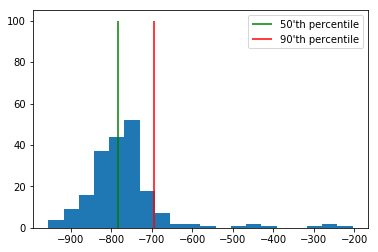

In [9]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(g_policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [
           100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [
           100], label="90'th percentile", color='red')
plt.legend()

## Crossentropy method steps

In [8]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    
    elite_states  = [states for states, reward in zip(states_batch, rewards_batch) if reward >= reward_threshold]
    elite_actions = [actions for actions, reward in zip(actions_batch, rewards_batch) if reward >= reward_threshold]
    #flatten both lists of lists
    elite_states = [item for sublist in elite_states for item in sublist]
    elite_actions = [item for sublist in elite_actions for item in sublist]
    return elite_states, elite_actions


In [9]:
states_batch = [
    [1, 2, 3],  # game1
    [4, 2, 0, 2],  # game2
    [3, 1]  # game3
]

actions_batch = [
    [0, 2, 4],  # game1
    [3, 2, 0, 1],  # game2
    [3, 3]  # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_40 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_40[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [10]:
def update_policy(elite_states, elite_actions, n_states, n_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """
    smoothing = 1 #add this thing to all counts for stability
    new_policy = np.zeros([n_states, n_actions])

    elite_counts = np.zeros_like(new_policy)
    
    for j in range(len(elite_states)):
        elite_counts[elite_states[j], elite_actions[j]] += 1

    
    for row in range(len(elite_counts)):
        row_sum = elite_counts.sum(1, keepdims=True)[row]
        for column in range(len(elite_counts[row])):
            elite_counts[row][column] = (elite_counts[row][column] / row_sum) if row_sum != 0 else 0
    new_policy = elite_counts   

    return new_policy


In [11]:
elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [
                               0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states, elite_actions, 5, 5)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


# Training loop

Generate sessions, select N best and fit to those.

In [27]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

Wall time: 763 ms


mean reward = -66.132, threshold=-74.000


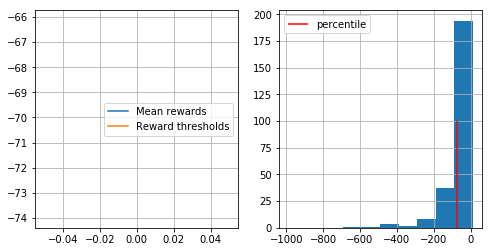

Wall time: 1.62 s


mean reward = -62.456, threshold=-74.000


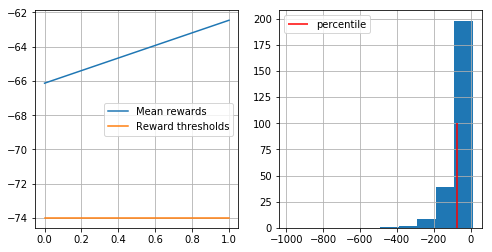

Wall time: 440 ms


mean reward = -57.088, threshold=-65.300


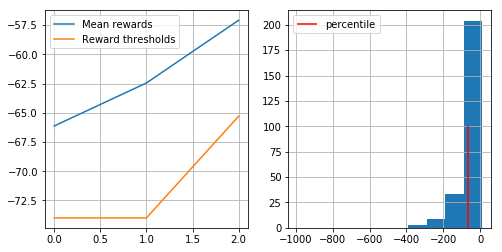

Wall time: 412 ms


mean reward = -60.524, threshold=-69.900


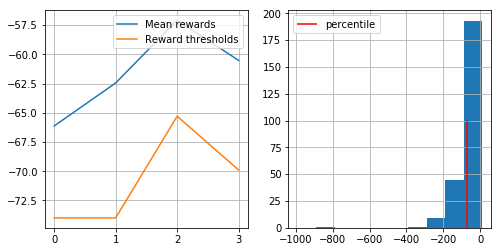

Wall time: 465 ms


mean reward = -61.436, threshold=-69.600


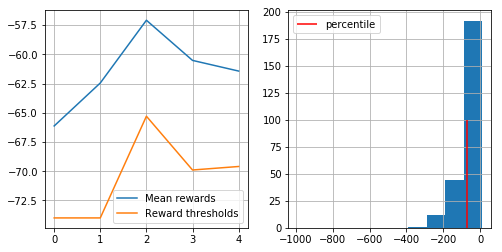

Wall time: 333 ms


mean reward = -60.300, threshold=-76.300


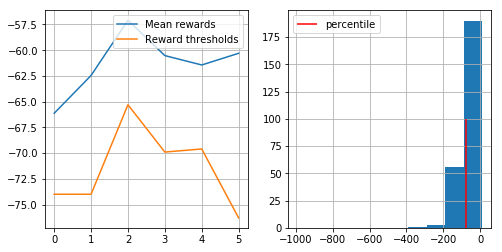

Wall time: 338 ms


mean reward = -68.112, threshold=-77.300


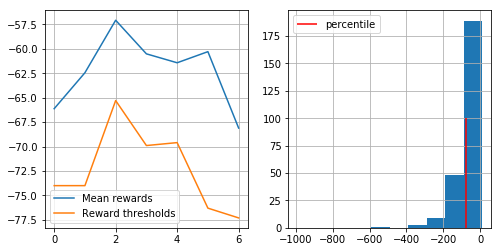

Wall time: 320 ms


mean reward = -60.716, threshold=-72.300


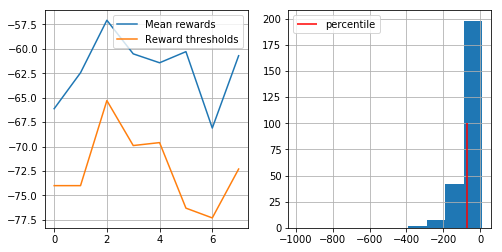

Wall time: 328 ms


mean reward = -59.276, threshold=-69.000


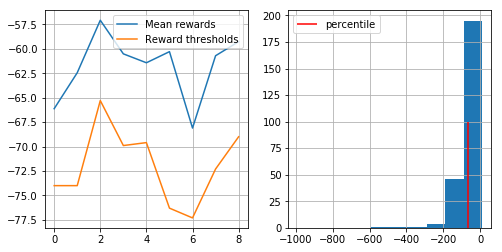

Wall time: 340 ms


mean reward = -68.988, threshold=-71.000


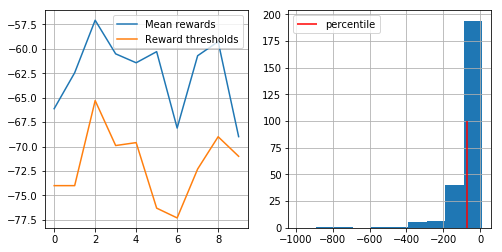

Wall time: 335 ms


mean reward = -66.504, threshold=-73.300


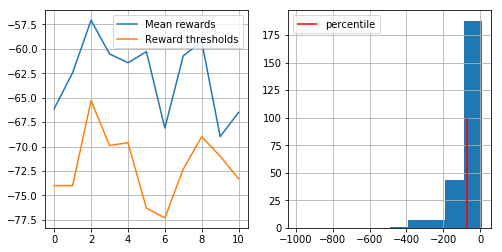

Wall time: 325 ms


mean reward = -62.644, threshold=-68.300


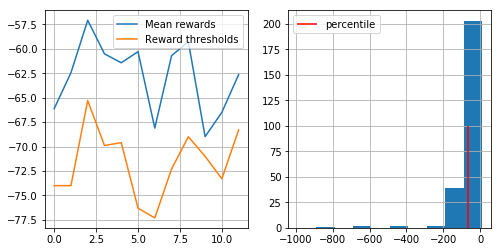

Wall time: 324 ms


mean reward = -61.040, threshold=-74.200


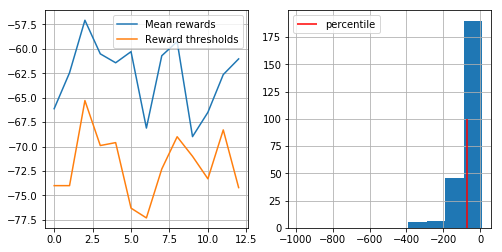

Wall time: 351 ms


mean reward = -64.780, threshold=-75.300


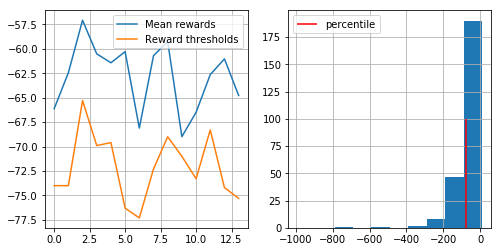

Wall time: 324 ms


mean reward = -54.076, threshold=-65.000


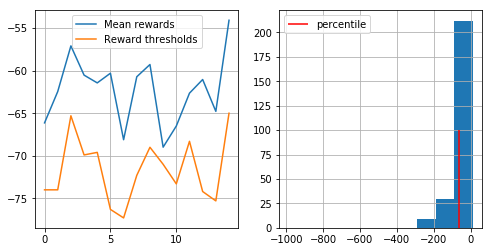

Wall time: 346 ms


mean reward = -56.404, threshold=-69.000


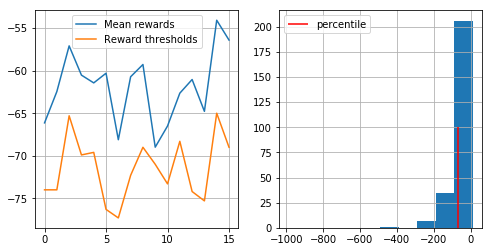

Wall time: 334 ms


mean reward = -59.828, threshold=-70.000


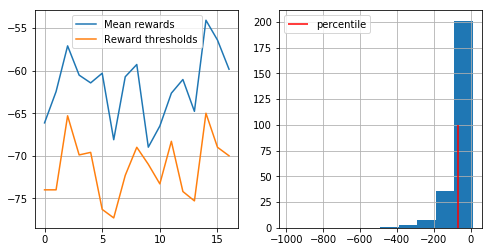

Wall time: 359 ms


mean reward = -69.608, threshold=-75.000


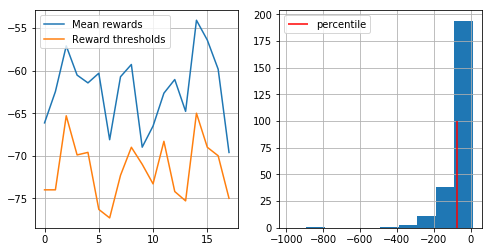

Wall time: 334 ms


mean reward = -59.380, threshold=-74.300


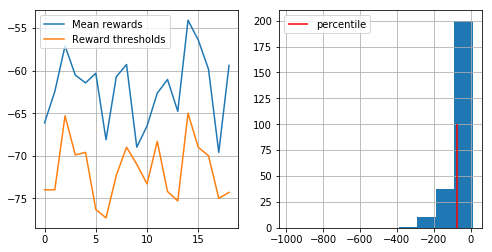

Wall time: 310 ms


mean reward = -55.860, threshold=-68.000


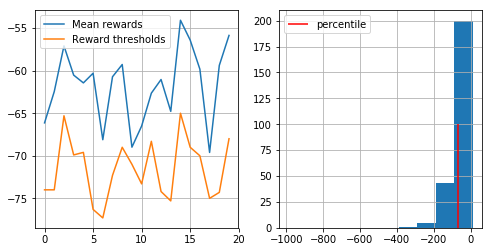

Wall time: 315 ms


mean reward = -56.724, threshold=-68.300


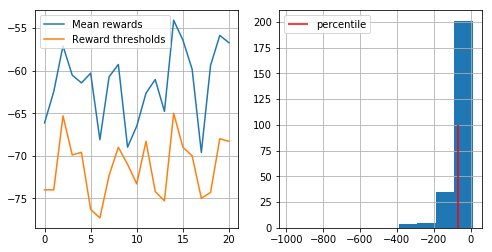

Wall time: 306 ms


mean reward = -55.692, threshold=-66.300


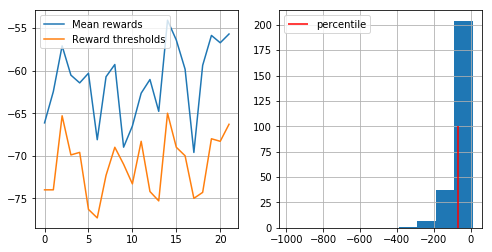

Wall time: 326 ms


mean reward = -59.084, threshold=-69.600


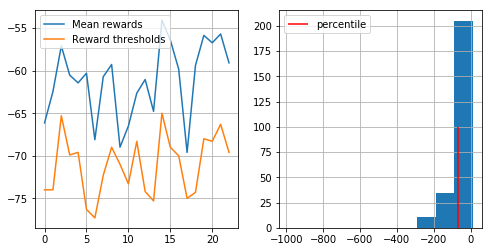

Wall time: 344 ms


mean reward = -62.908, threshold=-74.000


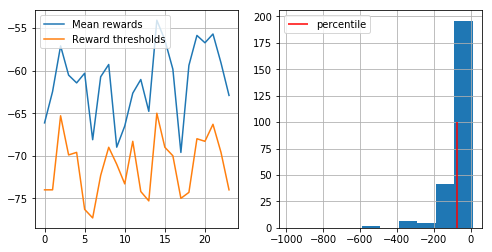

Wall time: 330 ms


mean reward = -61.020, threshold=-73.000


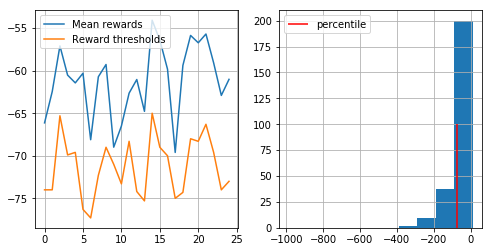

Wall time: 344 ms


mean reward = -68.316, threshold=-77.300


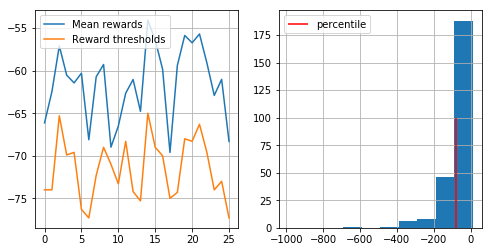

Wall time: 362 ms


mean reward = -74.164, threshold=-80.000


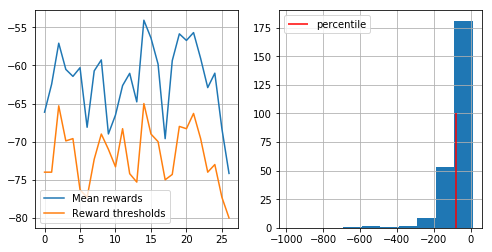

Wall time: 337 ms


mean reward = -63.676, threshold=-74.900


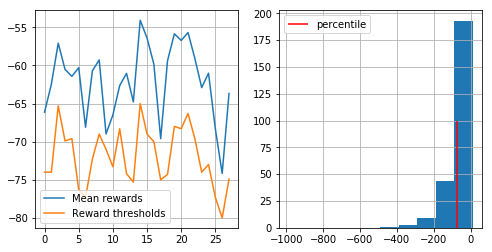

Wall time: 364 ms


mean reward = -73.872, threshold=-79.000


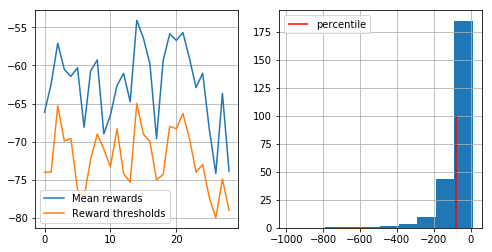

Wall time: 341 ms


mean reward = -64.508, threshold=-81.600


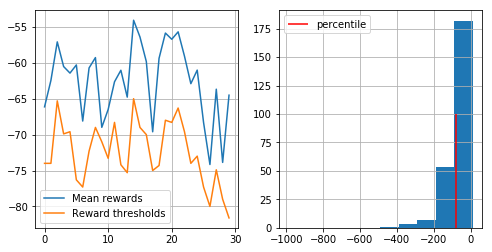

Wall time: 358 ms


mean reward = -70.996, threshold=-81.300


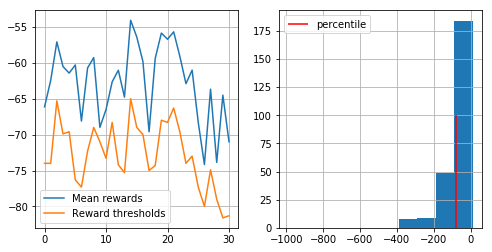

Wall time: 313 ms


mean reward = -58.960, threshold=-70.000


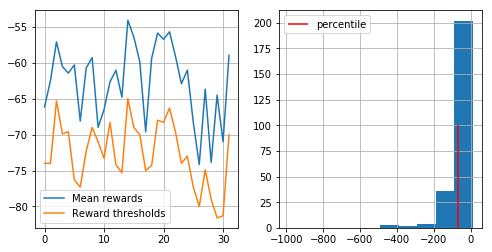

Wall time: 326 ms


mean reward = -62.540, threshold=-76.000


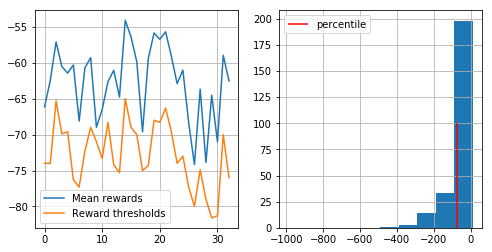

Wall time: 342 ms


mean reward = -62.440, threshold=-73.000


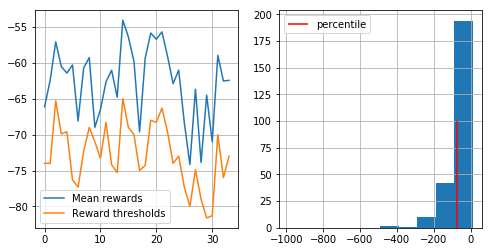

Wall time: 346 ms


mean reward = -60.032, threshold=-67.000


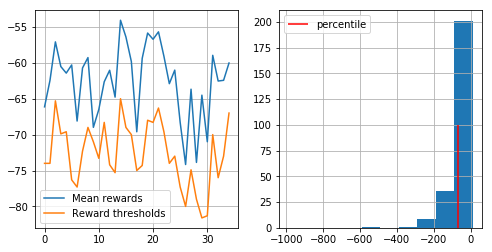

Wall time: 310 ms


mean reward = -57.764, threshold=-66.300


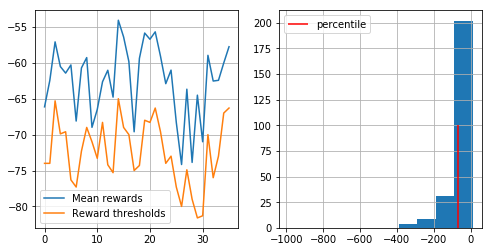

Wall time: 311 ms


mean reward = -58.372, threshold=-73.000


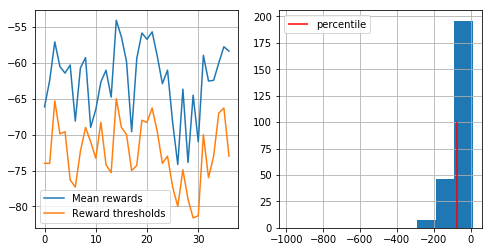

Wall time: 328 ms


mean reward = -61.448, threshold=-69.000


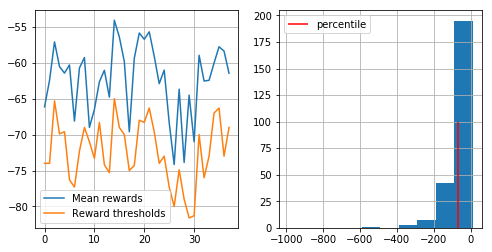

Wall time: 336 ms


mean reward = -70.168, threshold=-76.600


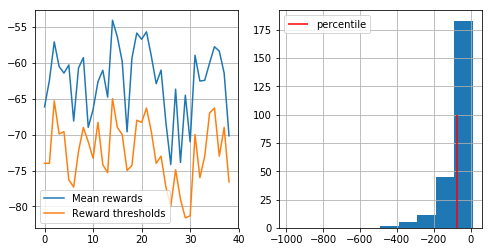

Wall time: 324 ms


mean reward = -64.660, threshold=-72.300


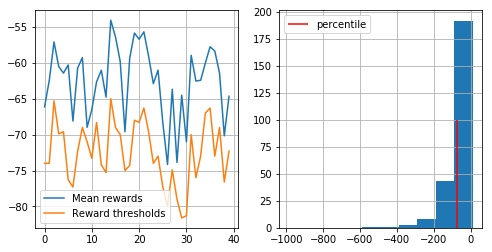

Wall time: 322 ms


mean reward = -64.988, threshold=-74.300


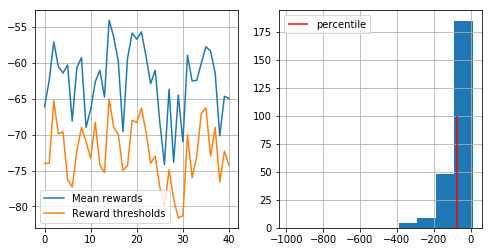

Wall time: 315 ms


mean reward = -59.920, threshold=-74.600


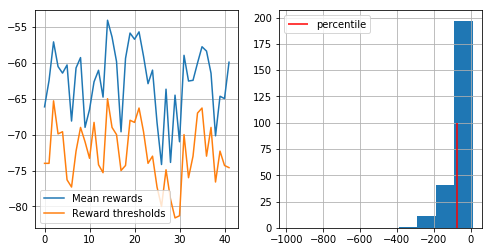

Wall time: 324 ms


mean reward = -61.224, threshold=-70.000


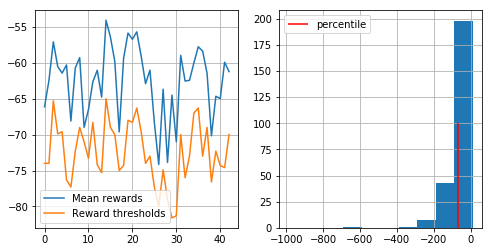

Wall time: 327 ms


mean reward = -59.736, threshold=-78.300


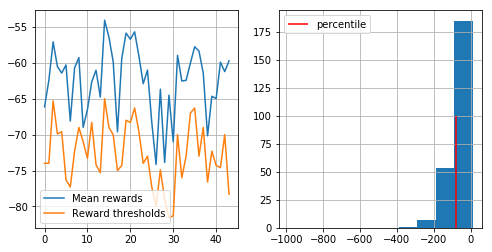

Wall time: 310 ms


mean reward = -58.480, threshold=-68.900


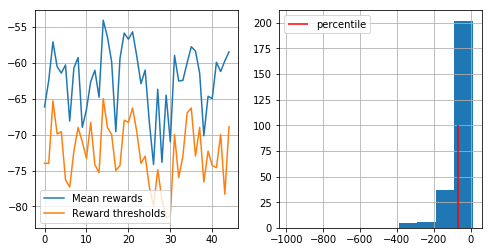

Wall time: 340 ms


mean reward = -68.960, threshold=-78.000


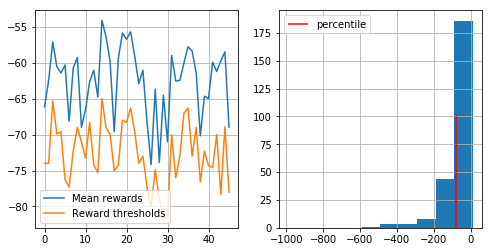

Wall time: 323 ms


mean reward = -61.396, threshold=-76.000


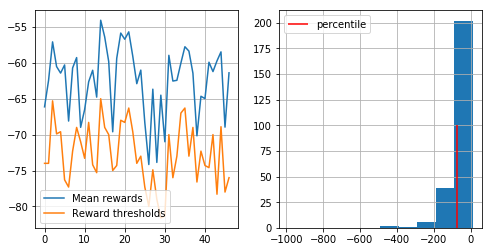

Wall time: 338 ms


mean reward = -64.608, threshold=-80.300


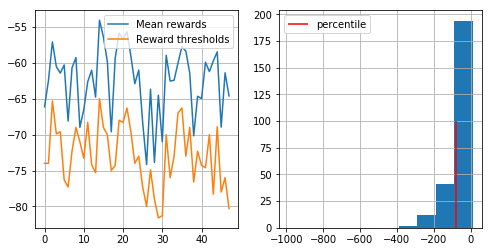

Wall time: 354 ms


mean reward = -72.436, threshold=-85.000


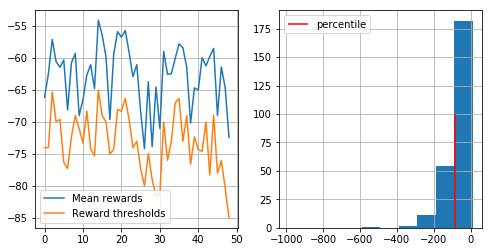

Wall time: 325 ms


mean reward = -59.804, threshold=-76.300


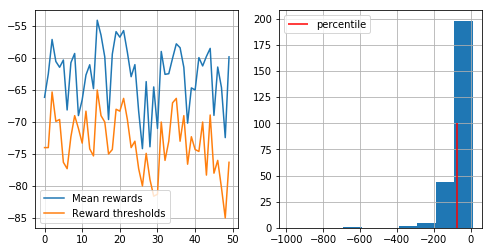

Wall time: 319 ms


mean reward = -60.488, threshold=-62.300


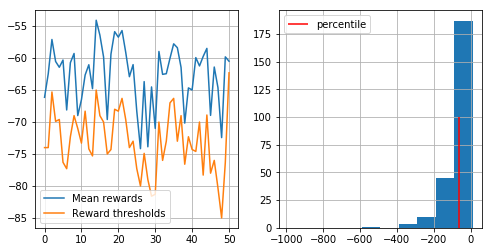

Wall time: 311 ms


mean reward = -57.376, threshold=-67.300


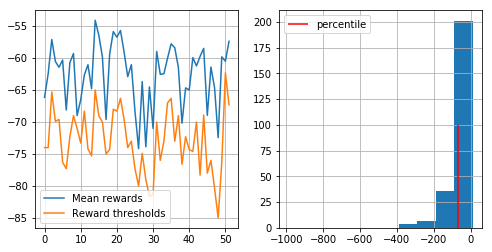

Wall time: 307 ms


mean reward = -55.688, threshold=-73.000


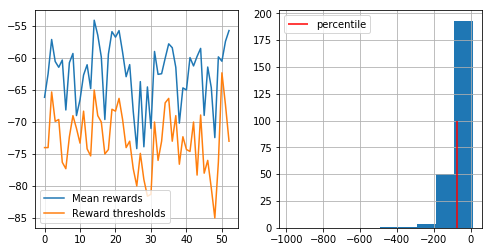

Wall time: 310 ms


mean reward = -58.008, threshold=-66.300


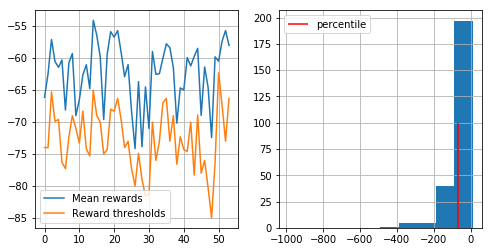

Wall time: 330 ms


mean reward = -69.248, threshold=-78.000


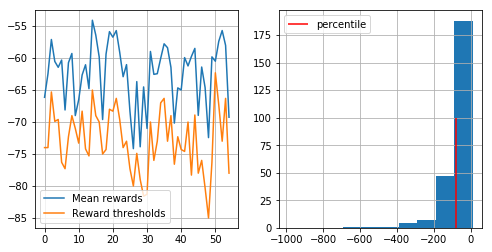

Wall time: 310 ms


mean reward = -59.892, threshold=-69.000


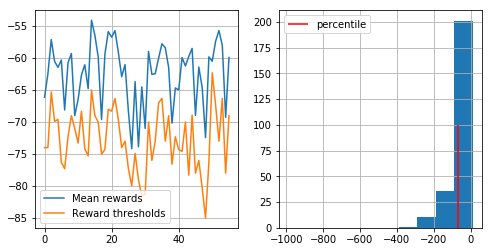

Wall time: 326 ms


mean reward = -67.756, threshold=-80.300


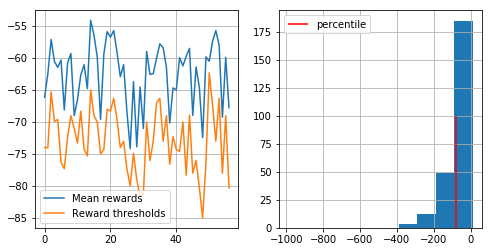

Wall time: 337 ms


mean reward = -64.292, threshold=-73.300


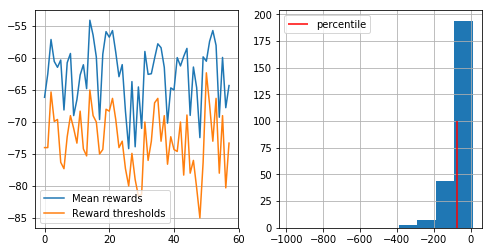

Wall time: 322 ms


mean reward = -63.908, threshold=-78.000


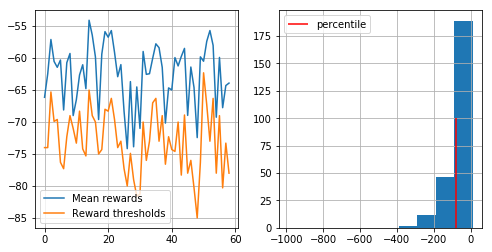

Wall time: 343 ms


mean reward = -67.904, threshold=-86.300


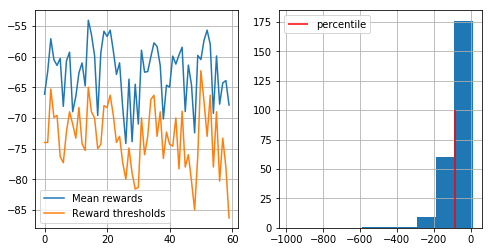

Wall time: 307 ms


mean reward = -60.304, threshold=-69.600


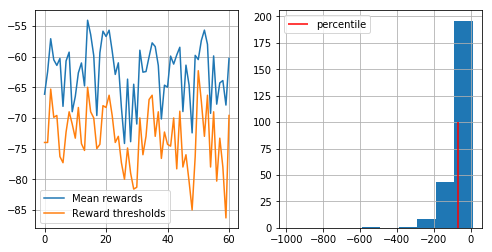

Wall time: 306 ms


mean reward = -58.684, threshold=-76.000


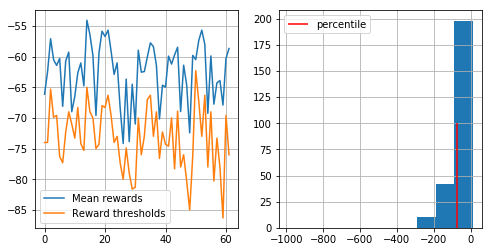

Wall time: 320 ms


mean reward = -64.468, threshold=-80.000


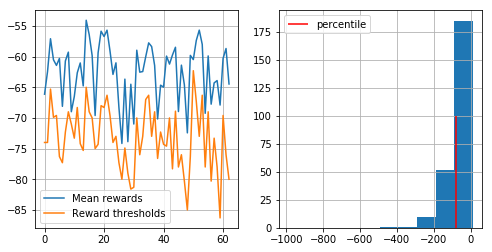

Wall time: 314 ms


mean reward = -59.364, threshold=-75.000


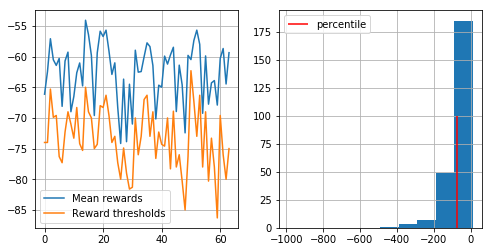

Wall time: 320 ms


mean reward = -64.000, threshold=-74.000


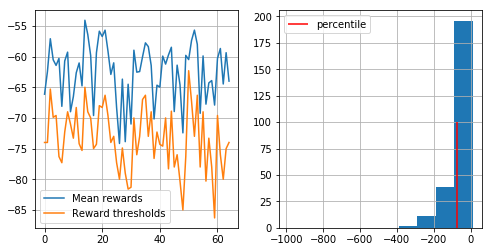

Wall time: 312 ms


mean reward = -54.792, threshold=-66.300


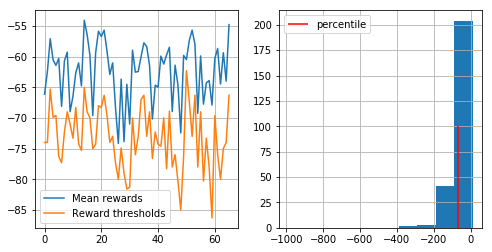

Wall time: 317 ms


mean reward = -63.128, threshold=-81.000


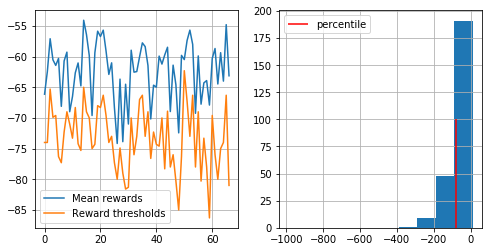

Wall time: 328 ms


mean reward = -65.724, threshold=-80.200


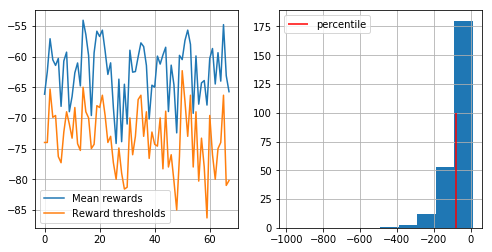

Wall time: 327 ms


mean reward = -63.052, threshold=-80.300


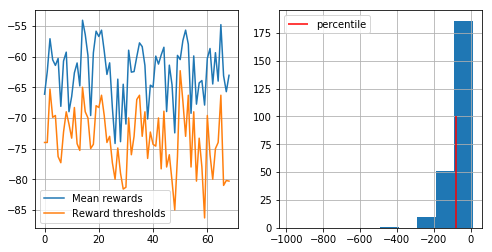

Wall time: 326 ms


mean reward = -63.364, threshold=-75.600


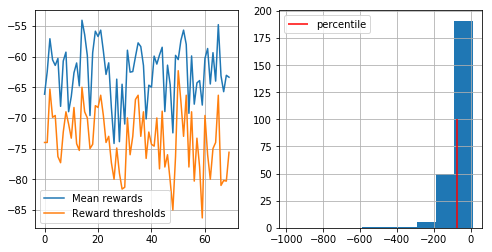

Wall time: 323 ms


mean reward = -61.448, threshold=-71.600


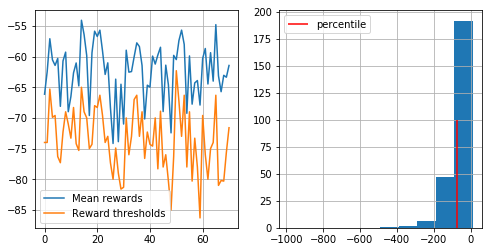

Wall time: 302 ms


mean reward = -53.256, threshold=-63.300


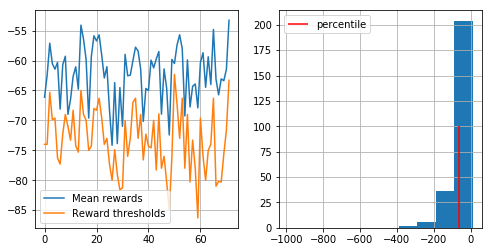

Wall time: 328 ms


mean reward = -60.412, threshold=-68.300


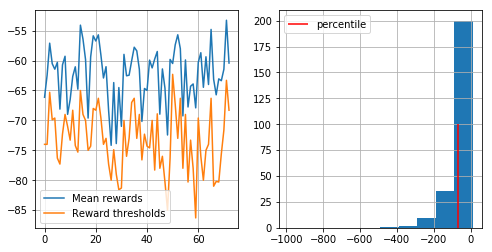

Wall time: 316 ms


mean reward = -55.200, threshold=-64.300


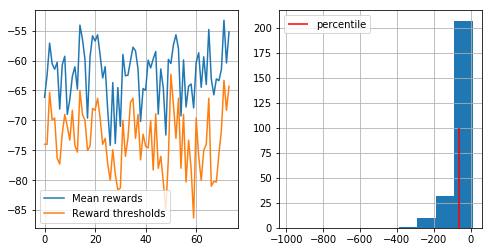

Wall time: 296 ms


mean reward = -53.680, threshold=-63.000


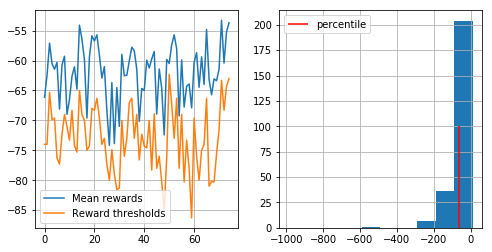

Wall time: 332 ms


mean reward = -67.304, threshold=-72.300


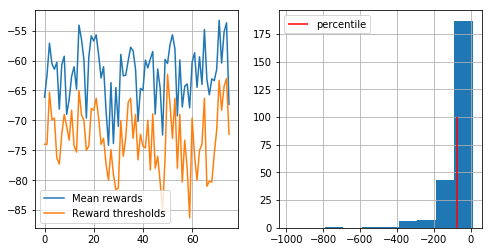

Wall time: 336 ms


mean reward = -60.284, threshold=-74.000


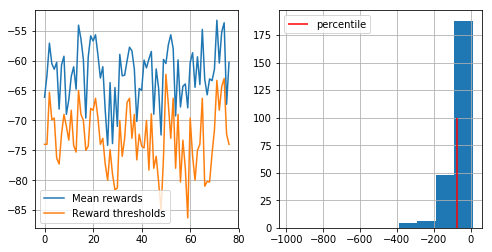

Wall time: 320 ms


mean reward = -56.076, threshold=-72.000


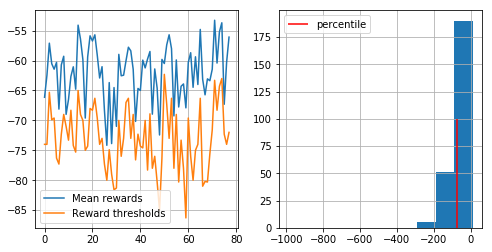

Wall time: 305 ms


mean reward = -56.496, threshold=-71.300


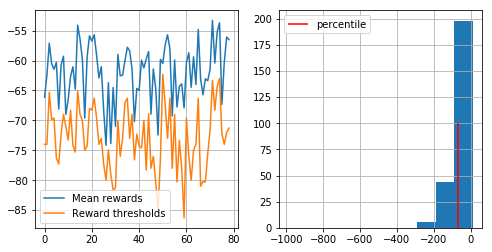

Wall time: 417 ms


mean reward = -55.712, threshold=-76.000


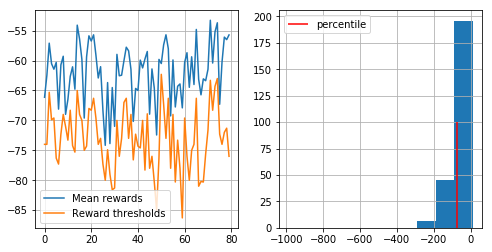

Wall time: 348 ms


mean reward = -54.684, threshold=-70.300


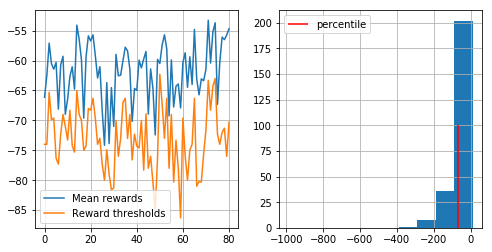

Wall time: 327 ms


mean reward = -51.064, threshold=-62.000


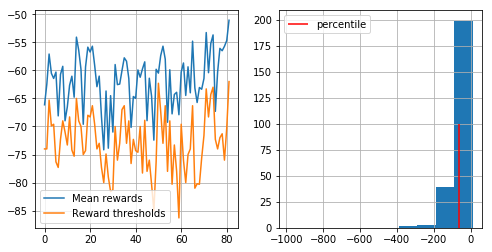

Wall time: 316 ms


mean reward = -54.956, threshold=-64.300


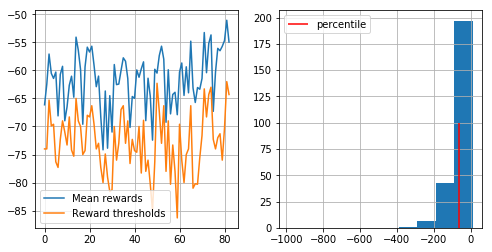

Wall time: 337 ms


mean reward = -69.100, threshold=-68.900


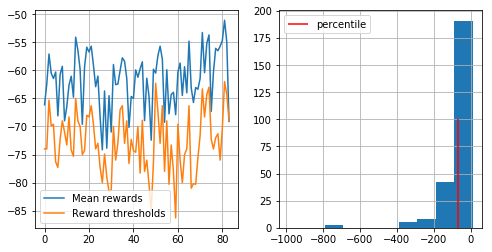

Wall time: 340 ms


mean reward = -66.344, threshold=-72.600


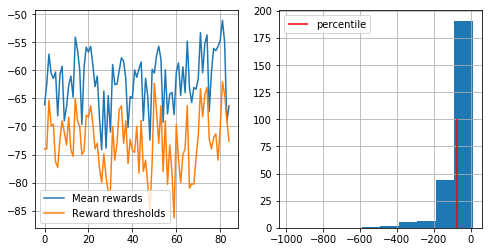

Wall time: 334 ms


mean reward = -61.048, threshold=-71.000


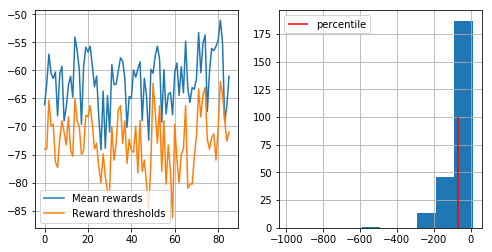

Wall time: 323 ms


mean reward = -62.824, threshold=-61.000


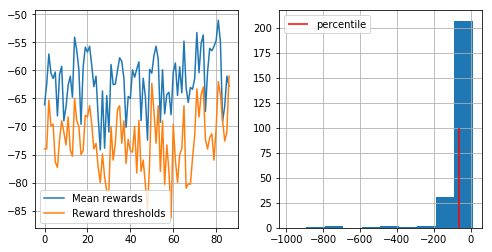

Wall time: 309 ms


mean reward = -51.316, threshold=-58.300


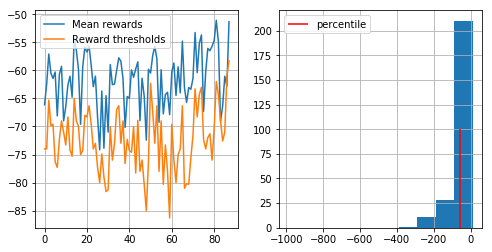

Wall time: 318 ms


mean reward = -58.324, threshold=-55.300


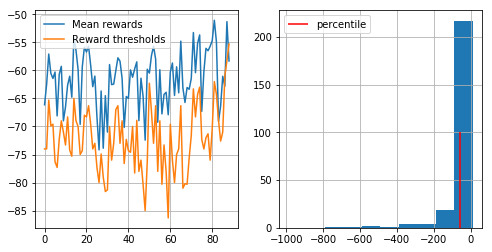

Wall time: 297 ms


mean reward = -51.700, threshold=-55.000


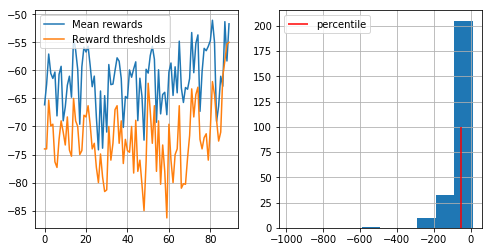

Wall time: 296 ms


mean reward = -47.476, threshold=-59.000


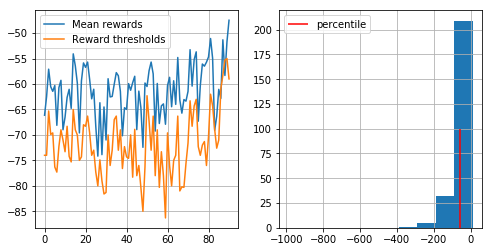

Wall time: 338 ms


mean reward = -63.700, threshold=-69.000


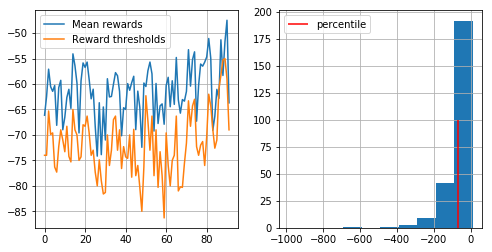

Wall time: 328 ms


mean reward = -60.052, threshold=-72.300


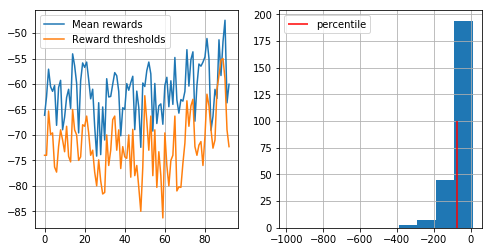

Wall time: 323 ms


mean reward = -59.180, threshold=-68.300


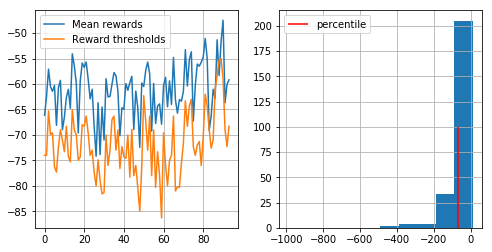

Wall time: 357 ms


mean reward = -73.508, threshold=-82.000


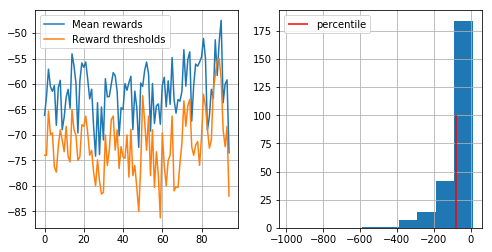

Wall time: 329 ms


mean reward = -66.888, threshold=-78.000


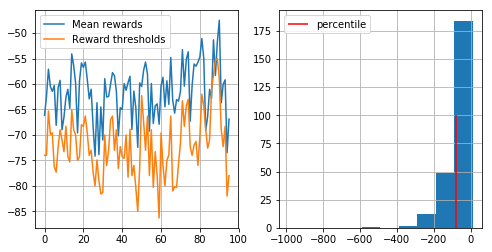

Wall time: 328 ms


mean reward = -65.452, threshold=-74.000


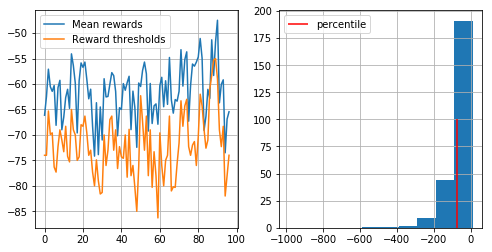

Wall time: 314 ms


mean reward = -60.092, threshold=-74.000


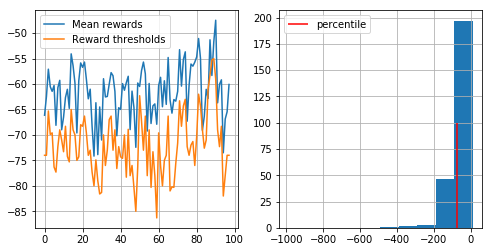

Wall time: 310 ms


mean reward = -57.876, threshold=-65.900


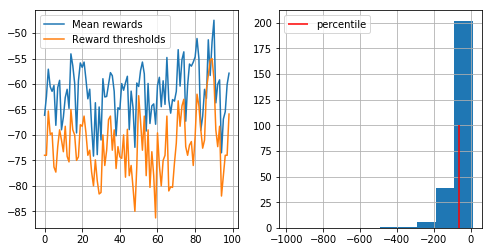

Wall time: 397 ms


mean reward = -69.472, threshold=-83.300


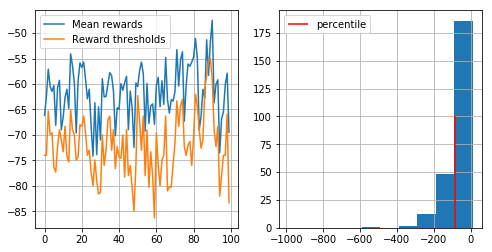

In [14]:
n_samples = 250 #sample this many samples
percentile = 30 #take this percent of session with highest rewards
smoothing = 0.3 #add this thing to all counts for stability

log = []
for i in range(100):
    
    %time sessions = [generate_session(g_policy) for i in range(n_samples)]
    
    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    
    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewars: a list of floats - total rewards at each session
    
    threshold = np.percentile(batch_rewards, percentile)
    
    elite_states = batch_states[batch_rewards > threshold]
    elite_actions = batch_actions[batch_rewards > threshold]
    
    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])

    elite_counts = np.zeros_like(g_policy) + smoothing
    
    for j in range(len(elite_states)):
        elite_counts[elite_states[j], elite_actions[j]] += 1
    
    g_policy = elite_counts/elite_counts.sum(1, keepdims=True)
    
    # display results on chart
    show_progress(batch_rewards, log)
    

# Approximate (deep) crossentropy method
In this section we will train a neural network policy for continuous action space game 

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n

#plt.imshow(env.render("rgb_array"))

In [17]:
#create agent

from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit() calls
                      max_iter=1 #make only 1 iteration on each .fit()
                      )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, range(n_actions))


D:\Tools\Python\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [18]:
def generate_session(t_max=10000):
    """
    Play game until end or for t_max ticks
    :param t_max: max ticks 
    :return:  list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        # predict array of action probabilities

        probs = agent.predict_proba([s])[0]

        a = np.random.choice(n_actions, p=probs)
        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done: break

    return states, actions, total_reward


In [19]:
n_sessions = 100
percentile = 70
smoothing= 0.01
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for __ in range(n_sessions)]

    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    
    threshold = np.percentile(batch_rewards, percentile)

    elite_states = batch_states[batch_rewards >= threshold]
    elite_actions = batch_actions[batch_rewards >= threshold]
    
    #elite_states: a list of states from top games
    #elite_actions: a list of actions from top games

    elite_states, elite_actions = map(np.concatenate, [elite_states, elite_actions])
    
    agent.fit(elite_states, elite_actions)
    print("mean reward = %.5f\tthreshold = %.1f" %(np.mean(batch_rewards), threshold))

   # show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

    if np.mean(batch_rewards) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

mean reward = 21.28000	threshold = 24.3


mean reward = 21.68000	threshold = 24.3


mean reward = 23.21000	threshold = 24.3


mean reward = 22.94000	threshold = 27.0


mean reward = 24.03000	threshold = 25.6


mean reward = 29.42000	threshold = 31.6


mean reward = 28.80000	threshold = 32.0


mean reward = 32.09000	threshold = 36.0


mean reward = 32.34000	threshold = 37.0


mean reward = 32.64000	threshold = 40.3


mean reward = 37.72000	threshold = 42.3


mean reward = 38.06000	threshold = 38.0


mean reward = 37.46000	threshold = 43.3


mean reward = 43.12000	threshold = 53.6


mean reward = 42.45000	threshold = 51.0


mean reward = 43.95000	threshold = 48.3


mean reward = 43.96000	threshold = 49.6


mean reward = 55.16000	threshold = 70.3


mean reward = 53.11000	threshold = 62.0


mean reward = 53.68000	threshold = 66.0


mean reward = 57.39000	threshold = 72.3


mean reward = 60.73000	threshold = 68.0


mean reward = 67.15000	threshold = 78.9


mean reward = 74.95000	threshold = 94.6


mean reward = 88.48000	threshold = 112.0


mean reward = 117.52000	threshold = 156.6


mean reward = 124.36000	threshold = 162.3


mean reward = 148.65000	threshold = 200.0


mean reward = 170.10000	threshold = 200.0


mean reward = 169.08000	threshold = 200.0


mean reward = 184.42000	threshold = 200.0


mean reward = 191.46000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 195.92000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 194.95000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 195.53000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.56000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.68000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.53000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 195.16000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.42000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.15000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.60000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 195.39000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.32000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 196.90000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.26000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.97000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.92000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.46000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.45000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.76000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.19000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.09000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.19000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 197.80000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.75000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.18000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.12000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.43000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.56000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.84000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.95000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.05000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 196.41000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.80000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.24000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.48000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.62000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.39000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.83000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.90000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.83000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 199.99000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 198.90000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


mean reward = 200.00000	threshold = 200.0
You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

# Results

In [20]:
# record sessions
import gym.wrappers

env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)

sessions = [generate_session() for _ in range(100)]
env.close();

In [22]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

<video width="640" height="480" controls>
  <source src="./videos/openaigym.video.0.104.video000064.mp4" type="video/mp4">
</video>